# Using ML for Energy Usage in Buildings

In this work the application of machine learning (ML) techniques to building data, specifically smart meter data, is demonstrated. For this purpose, the REFIT smart homes data set is utilised, containing half hourly gas consumption, indoor temperature, radiator surface temperature and further data at multiple location in the building [1]. Firstly, supervised learning techniques are applied to predict gas consumption using regression and classification.  Seccondly, unsupervised learning is used to identify clusters of 24-hour gas consumption patterns. Finally, Reinforcement Leaning is used to train a car to reach a flag on top of a hill.

# Pre-processing 
The REFIT data must be pre-processed, to train an ML algorithm on it. 

In [1]:
# importing libraries 
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

The data has already been resampled to 30 min periods, pivoted and values for the same sensor values were concaternated, so the dataframe (df) is in the correct format to be imported. 


In [2]:
# reading csv - building 1 is selected 
df = pd.read_csv('Building01_new.csv', header=[0,2,3], index_col= 0)

### Missing Values

First the df must be cleaned of missing values. 

In [3]:
df[('Gas volume', 'Meter1','nan')].isna().sum()

4877

There are 4877 rows where `Gas volume` has `NaN` values, which should all be dropped. Furthermore, rows in which all features except `Gas volume` are `NaN` values are dropped. 

In [4]:
# dropping rows for which the Gas volume is na 
df = df[df[('Gas volume', 'Meter1','nan')].notna()]
# dropping rows in which gas volume is the only not-na value 
df = df.dropna(axis=0, thresh=26)
#df.isna().sum() # uncomment to see missing values in each col 

`df.isna().sum()` checks which other features have missing values (commented out for space purposes). There are columns that have few entries. Thus, if more than 20 % of a column is missing, the feature will be removed.

In [5]:
# removed columns that have more than 20% missing values 
df = df.loc[:, pd.notnull(df).sum()>len(df)*0.8]
# df.isna().sum() - uncomment to see missing values in each col

As there are still missing values, these must be **interpolated**. In this case the median is used. <br> 

In [6]:
df_filled = df.fillna(df.median())
print(f'There are {df_filled.isna().sum().sum()} missing values')

There are 0 missing values


In [7]:
# combining all headers into one & stripping the suffix of the column names
df_filled.columns = df_filled.columns.map(''.join).str.replace('nan', '')

### Scaling & Normalising

Next, the values are scaled, as features have different units and thus different orders of magnitude.

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame()
df_scaled[df_filled.columns] = scaler.fit_transform(df_filled[df_filled.columns])

# Task 1 – Supervised Learning 
## Aims and Introduction
Supervised Leaning uses labelled data to train an algorithm to perform a prediction [2]. In this task, two types of supervised learning, classification, and regression are used to predict whether the gas in a building is used (on/off) and how much gas is being used, respectively. For each classification and regression, two algorithms are trained, tested, and tuned to evaluate which one yields better results.

## Features Selection 

For supervised learning, the relevant features for the model must be selected. First, a correlation matrix is plotted to visulalise how features are correlated with each other. 

<AxesSubplot:>

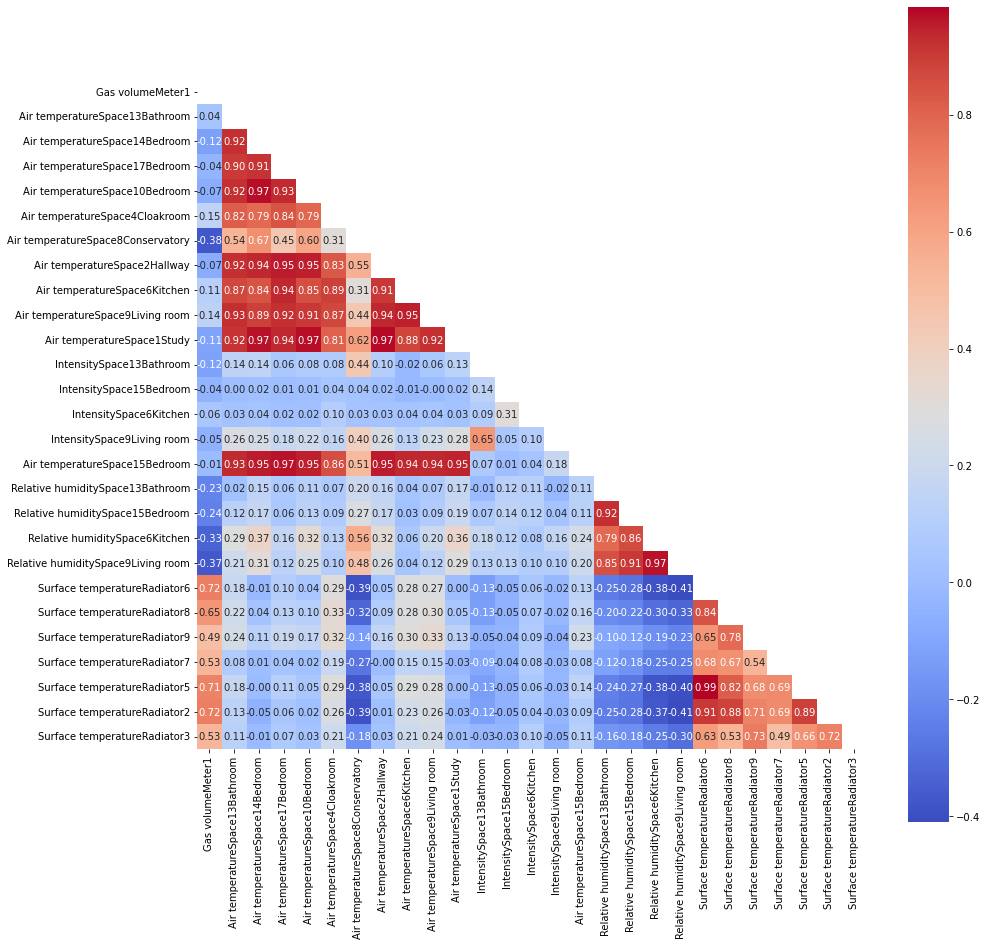

In [11]:
# correlation matrix 
matrix = np.triu(df_scaled.corr())  

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_scaled.corr(), annot=True, cmap='coolwarm', fmt='.2f', 
            square=True, ax=ax, mask = matrix)

The surface temperatures of the radiators have the highest correlation with `Gas Volume`. This makes intuitive sense, as most gas consumption in households goes towards heating. The air temperatures, surface temperatures, and relative humidities are very strongly correlated with the same measurement in a different space. To avoid the problem of **multicollinearity**, only the features with the highest correlation to `Gas Volume` are kept for each category. 

The correlation matrix only captures a linear relationship between coefficients, as it uses the Pearson correlation coefficient. To identify any non-linear relationships, the features with low correlation (intensities) are plotted against the target on individual plots.

In [12]:
intensity = ['IntensitySpace9Living room', 'IntensitySpace13Bathroom',
                'IntensitySpace15Bedroom', 'IntensitySpace6Kitchen',
             'IntensitySpace9Living room',]

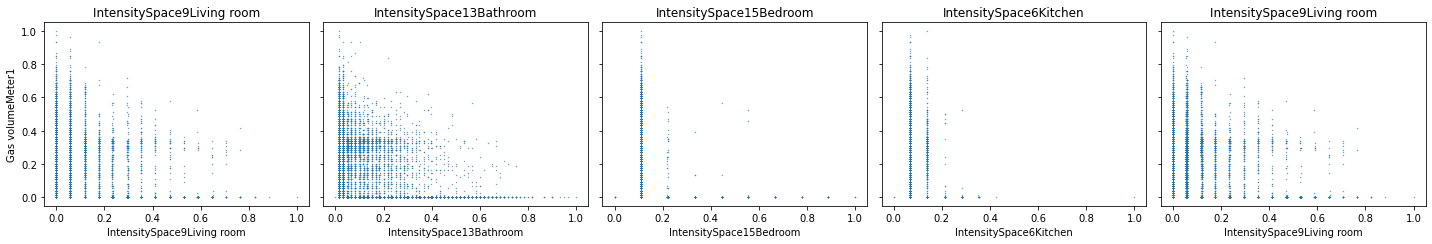

In [13]:
fig, axes = plt.subplots(1,5, sharey = True, figsize = (20,3.5))
ax = axes.flatten()

for i, feature in enumerate(intensity):
    df_scaled.plot.scatter(x = feature, y = 'Gas volumeMeter1', ax = ax[i], s = 0.1)
    ax[i].set_title(feature)
    
for j in range(i+1, len(ax)): ax[j].axis('off') 
plt.tight_layout()

There seeems to be a meaningful relationship between`IntensitySpace13Bathroom` (and other `Intensity`'s) and `Gas Volume`. Therefore, `IntensitySpace13Bathroom` is also used as feature.

In [14]:
features_sel = ['Air temperatureSpace8Conservatory','Surface temperatureRadiator6',
               'Relative humiditySpace9Living room','IntensitySpace13Bathroom']
X = df_scaled[features_sel]   # only selected columns used as features

## Theory 
### Classification 
For the classification task, the performance of a support vector machine (SVM) and random forest (RF), will be compared against each other, by means of a confusion matrix, the accuracy and the F1 score.
#### Support Vector Machine (SVM) 
A support vector machine (SVM) aims at finding the optimal hyperplane to separate two or more classes. The support vectors are the closest data points to the other class and therefore the hardest to classify. The optimal hyperplane is found by maximising the distance to the support vectors (creating the largest margin between hyperplane and support vectors) and is therefore also known as *Large Margin Classifier* (see Figure 1)[3]. 
<br>

<p >
    <img src="images/svm.png" width="350" />
 <p> <br>
Figure 1: Right: options for separation; Left: optimal separation  [4] 

#### Random Forest (RF)
A random forest (RF) is an algorithm that consists of multiple decision trees (DT) [5]. A DT is an algorithm that makes a decision depending on the value of certain features. It starts with one node that contains a condition, in this case the weather. Depending on the value of the feature (Sun, Cloud, Rain) the path is followed to the next node, and the procedure is repeated until an outcome is produced in the leaf node (here depicted in yellow) [6]. When a DT is trained, the Information Gain or Gini Impurity is used to decide which features to split on. DTs are easily overfitted if the tree is too large. This means it perfectly represents the training data but then performs poorly on testing data, exhibiting high variance and low bias.

<p >
    <img src="images/dt.png" width="300" />
<p> <br>
Figure 2: Example of a decision tree [6]

The RF avoids the problem of overfitting by using a method called bagging [5]. A subset of the data and the features are sampled with replacement, and the DT is fit to this bagged subsample. The individual trees are allowed to overfit, as the results of all trees are later averaged. Taking a subset of all features ensures that there is not one feature that dominates each DT by having a very high Information Gain. This ensemble method turns a weak classifier (the DT) into a strong classifier (RF).

A disadvantage of random forests is that they are much less interpretable than decision trees. The choice between DT and RF, therefore, depends on the application [7]. Here, the aim is to classify whether the gas in a house is turned on or off as accurately as possible. With an emphasis on accuracy rather than explainability, a random forest is more appropriate.
<br>
<br>

### Regression 
For the regression task, two regression algorithms were used to predict the volume of gas consumed during every half-hour timeslot. The algorithms used are support vector regression (SVR) and k-nearest neighbour (kNN). The performance of both algorithms is compared using the root mean square error (RMSE), mean absolute error (MAE) and the coefficient of determination (R2).  

#### Support Vector Regression (SVR)
Support vector regression works on the same basis as the support vector machine classifier. However, instead of separation between classes, in support vector regression separates between errors. The e-insensitive error function, shown below, is mostly used as the cost function that must be minimised [3].

<p>
    <img src="images/e_insensitive.png" width="300" />
<p>

The epsilon defines the size of the error that is allowed. If a point sits inside the tube of acceptable error, shown in Figure 3, the cost is zero. Otherwise, the cost is the absolute difference between the predicted and actual value [3]. 

<p>
    <img src="images/svr.png" width="300" />
<p> <br>
Figure 3: Tube of acceptable error [3]

#### K-Nearest Neighbours (kNN) 
K-nearest Neighbours is a supervised learning algorithm working with distances as similarity measure. In regression, the mean of the k-nearest targets is calculated to predict the target for the new data point [8]. An example of kNN with k = 3 is shown below, where the weight of a person is inferred from their height and age. The weights for the three closest points are known and can be averaged to predict the weight of the person with the yellow data point [9]. The k must be selected before applying the algorithm. 

<p>
    <img src="images/knn.png" width="300" />
<p> <br>
Figure 4: Example of kNN with k = 3 [9]

## Subtask a) Classification 
In order to classify whether gas is being consumed (1) or not (0), classes must be defined first. 

In [15]:
df_filled['Gas on/off'] = np.where(df_filled['Gas volumeMeter1'] > 0, 1, 0)
y = df_filled['Gas on/off']

In [16]:
y.value_counts()

0    16671
1     9939
Name: Gas on/off, dtype: int64

We are dealing with unbalanced data. Adding a penalisation term to the SVM helps to counteract this, while random forests are generally good with dealing with unbalanced data.

### Train Test Split

In [17]:
from sklearn.model_selection import train_test_split
# train test split for classification 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Classification Model 1 - Support Vector Machine (SVM)

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

#### Model Tuning 

The model is tuned on a grid of hyperparamters. The default hyperparameter are part of this grid, in case they yield the best performance. 

In [19]:
import time 
from sklearn.model_selection import GridSearchCV

In [20]:
params = {'C' : [1, 10 ,100], 
          'kernel':['linear', 'poly','rbf','sigmoid']} 

tt = time.time()                       # starting time 
svm = SVC(class_weight='balanced')     # initialising SVM classifier 
svm = GridSearchCV(svm, params)        # specifing parameter and classifier 
svm.fit(X_train, y_train)              # performing grid search for given data

print('Performed grid search in %.2fs' %(time.time()-tt)) # end time 

Performed grid search in 1193.63s


### Classification Model 2 - Random Forest 

#### Tuning and Training 

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf_params = {'max_depth' : [None, 10, 20, 30], 'min_samples_split' : [2, 5, 10]}

tt = time.time()                 # starting time 
rf = RandomForestClassifier()    # initialising SVM classifier 
rf = GridSearchCV(rf, rf_params) # specifing parameter and classifier 
rf.fit(X_train, y_train)         # performing grid search for given data

print('Performed grid search in %.2fs' %(time.time()-tt)) # end time 

Performed grid search in 104.35s


### Classification Results
#### SVM Results 

In [23]:
print(f'The best parameters are: {svm.best_params_}, with highest accuracy: {svm.best_score_:.2f}')

The best parameters are: {'C': 100, 'kernel': 'rbf'}, with highest accuracy: 0.91


A high C indicates a smaller margin, intending to produce fewer misclassifications [10]. This could lead to overfitting. However, `C = 100` seems adequate in this scenario, as the results produced from the test data are even better than the cv results. `rbf` is one of the most commonly used kernels.

In [25]:
# training and predicting with tuned SVM
svm_best = SVC(C=svm.best_params_['C'], kernel=svm.best_params_['kernel'],
                class_weight='balanced').fit(X_train, y_train)
y_pred_best = svm_best.predict(X_test)

#confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred_best)
confusion_df = pd.DataFrame(conf_matrix,index=['Off (0)', 'On (1)'], 
                            columns=['Off (0)', 'On (1)'])          
confusion_df = pd.concat({'Predicted':pd.concat({'True':confusion_df})},axis = 1)
confusion_df 

Predicted       
               Off (0) On (1)
True Off (0)      3096    247
     On (1)        237   1742

The **confusion matrix** for the tuned SVM is displayed above. It shows that gas was classified as  `On` 247 times, when it was actually `Off`, and predicted to be `Off` 237 times when it was actually `On`. It seems like the penalisation term in the SVM has overcome the problem of class imbalance. However, the **classification report** shows a f1-score for the prediction of `Off` that is considerably higher than for `On`, suggesting class imbalance it not overcome.

In [26]:
print(classification_report(y_test, y_pred_best, labels = None, 
                            target_names = ['Off (0)', 'On (1)']))

              precision    recall  f1-score   support

     Off (0)       0.93      0.93      0.93      3343
      On (1)       0.88      0.88      0.88      1979

    accuracy                           0.91      5322
   macro avg       0.90      0.90      0.90      5322
weighted avg       0.91      0.91      0.91      5322



The accuracy for the classification with SVM is 0.91, which is satisfactory for this analysis. 

#### Random Forest Results 

In [27]:
print(f'The best parameters are: {rf.best_params_}, with highest accuracy:{rf.best_score_:.2f}')

The best parameters are: {'max_depth': 30, 'min_samples_split': 10}, with highest accuracy:0.92


`max depth` defines how large the individual DT can grow [11]. For the training set, the larger the tree, the better will be the performance. However, larger trees are also more likely to overfit. `min_samples_split` defines the minimum observations in a node to split on (ibid). This means small values of `min_samples_split` tend to overfit. `max_depth: 30` and `min_samples_split': 10` are unlikely to overfit, especially because they are used in a RF

In [28]:
# training and predicting with tuned RF
best_rf = RandomForestClassifier(max_depth = rf.best_params_['max_depth'], 
    min_samples_split = rf.best_params_['min_samples_split']).fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)

#confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred_rf)
confusion_df = pd.DataFrame(conf_matrix,index=['Off (0)', 'On (1)'], 
                                        columns=['Off (0)', 'On (1)'])                                                
confusion_df = pd.concat({'Predicted':pd.concat({'True':confusion_df})},axis=1) 
confusion_df

Predicted       
               Off (0) On (1)
True Off (0)      3147    196
     On (1)        247   1732

The RF produces less misclassification for both `Off` and `On` than the SVM. The problem of class imbalance is more visible here, in both confusion matrix and classification report.

In [29]:
print(classification_report(y_test,y_pred_rf,target_names = ['Off (0)', 'On (1)']))

              precision    recall  f1-score   support

     Off (0)       0.93      0.94      0.93      3343
      On (1)       0.90      0.88      0.89      1979

    accuracy                           0.92      5322
   macro avg       0.91      0.91      0.91      5322
weighted avg       0.92      0.92      0.92      5322



The RF classifies gas consumption with slightly higher accuracy than the SVM, 0.92 and 0.91, respectively. Furthermore, the RF performs the grid-search considerably faster than the SVM.

## Subtask b) Regression 

In [30]:
y = df_scaled['Gas volumeMeter1']

### Train Test Split

In [31]:
# train test split for regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Regression Model 1 - Support Vector Regression (SVR) 

In [32]:
from sklearn.svm import SVR

#### Tuning and Training

In [33]:
# grid with hyperparameters 
svr_params = {'C' : [1, 10, 100], 'kernel':['rbf','sigmoid', 'linear', 'poly' ]}  

tt = time.time()

svr = SVR()                       
svr_gs = GridSearchCV(svr, svr_params)    
svr_gs.fit(X_train, y_train)                    

print('Hyperparameters wered tuned in %.2fs' %(time.time()-tt))

Hyperparameters wered tuned in 21173.87s


### Regression Model 2 - K-Nearest Neighbour (kNN)

In [34]:
from sklearn.neighbors import KNeighborsRegressor

#### Tuning and Training 

In [35]:
# gird with hyperparameters 
knn_params = {'n_neighbors':np.arange(1, 30, 2), 'weights':['uniform', 'distance']} 

tt = time.time()

knn = KNeighborsRegressor()                       
knn_gs = GridSearchCV(knn, knn_params)    
knn_gs.fit(X_train, y_train)                    

print('Hyperparameters were tuned in %.2fs' %(time.time()-tt))

Hyperparameters were tuned in 11.14s


### Regresssion Results

In [36]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

#### SVR Results

In [51]:
print(f'The best parameters are: {svr_gs.best_params_}, with highest R2: {svr_gs.best_score_:.2f}')

The best parameters are: {'C': 1, 'kernel': 'linear'}, with highest R2: 0.50


In [38]:
best_svr = SVR(C = svr_gs.best_params_['C']).fit(X_train, y_train)
y_best_pred = best_svr.predict(X_test)

print(f'R2:{r2_score(y_test, y_best_pred):.3f}')
print(f'MAE: {mean_absolute_error(y_test, y_best_pred):.3f} m3')
print(f'RMSE: {mean_squared_error(y_test, y_best_pred, squared = False):.3f}')

R2:0.441
MAE: 0.097 m3
RMSE: 0.117


#### kNN Results 

In [52]:
print(f'The best parameters are: {knn_gs.best_params_}, with highest R2: {knn_gs.best_score_:.2f}')

The best parameters are: {'n_neighbors': 29, 'weights': 'distance'}, with highest R2: 0.59


`n_neighbors` indicates the number of neighbors that are considered when predicting the class of a new data point [12]. A low k would make the algorithm prone to underfitting. `distance` as weight measure means that closer points influence the prediction more than further away points (ibid). 

<br>

In [40]:
best_knn = KNeighborsRegressor(weights = knn_gs.best_params_['weights'], 
            n_neighbors = knn_gs.best_params_['n_neighbors']).fit(X_train, y_train)
y_best_pred = best_knn.predict(X_test)

print(f'R2:{r2_score(y_test, y_best_pred):.3f}')
print(f'MAE: {mean_absolute_error(y_test, y_best_pred):.3f} m3') 
print(f'RMSE: {mean_squared_error(y_test, y_best_pred, squared = False):.3f}')

R2:0.621
MAE: 0.049 m3
RMSE: 0.096


The kNN performs better than the SVR. However, both are R2's are relatively low (SVM: 0.44 and kNN: 0.62 on training data). This might mean that they are not adequate for the exact prediction of gas consumption in this household. Equally to the classification task, the SVR takes much longer to perform the cv grid search than the kNN (even when having fewer parameters). The kNN is not overfitting, as can be seen from the fact that the results of test data are better than average cv results for best parameters. The SVM might be underfitting the model, as R2 is low and `C = 1` and the `linear` kernel is used.

## Supervised Learning - Conclusion

The RF performs slightly better than the SVM for classification, while being much faster at training the model. Therefore, it should be used to classify whether the gas is on or off. Neither the SVM nor the RF managed to properly deal with the class imbalances. In the future, a resampling technique, such as over or undersampling, could be used to try to improve the results further. 

The kNN outperforms the SVM for the regression task, however, neither performance is excellent. Again, training the SVR takes longer than the kNN. The SVR should not be used, as both results and performance time are worse than for the kNN. The use of the kNN might be considered, depending on how accurate of a prediction is required.  

The training and testing was also implemented on all features, resulting a considerably worse performance for all algorithms. This demonstrates a successful features selection. 

There are some limitation of this the approach taken as well as the dataset. Firstly, a large amount of data could not be used due to too much missing data. Further, there is always some degree of measurement error involved when collecting sensor data. ML algorithms are only as good as the data that they are given. The amount of hyperparameter that could be tested was limited due to computational and time constraints. It took the SVR alone multiple hours to perform the grid search cross validation on 7 hyperparameters. Another limitation of the used ML algorithms is their interpretability. If more interpretable results are required, different methods must be used.  

In the future further hyperaparameters and other algorithms should be used to try and improve performance, especially for the regression task. 
<br>
<br>
<br>
<br>

# Task 2 - Unsupervised Learning 

## Aims and Introduction

In this task, unsupervised learning, specifically the k-means algorithm is used to identify clusters within the REFIT data set. Unsupervised learning derives its name from the fact that it uses unlabelled data, and thus cannot be supervised [13]. Unsupervised learning can detect patterns, such as clusters, which would be hard to spot for humans due to the complexity of large data sets [3]. Generally, clusters are groups of data points that have something in common, e.g., a similar energy demand pattern. The specific aim of this section is to cluster gas usage patterns over a 24-hour period. Therefore, hourly values are taken for every day and then clustered into different usage patterns. 

## Theory
### K-means
K-means is a type of unsupervised clustering algorithm. First, k - the number of clusters that will be identified - must be defined. Next, the centroids of the clusters are initialised randomly. Each data point is then assigned to the nearest cluster. Finally, the centroids are updated. These steps are repeated until convergence [14]. By repeating the procedure multiple times and assessing the variation within the clusters each time, the optimal clusters can be found. Selecting k a-priori can be a limitation for the algorithm, as often the appropriate number of clusters is not known [15]. Furthermore, k-means is very dependent on its randomly initialised centroids.  For an interactive example of k-means clustering see: https://www.naftaliharris.com/blog/visualizing-k-means-clustering/ 


### Elbow Plot
An elbow plot can be used to find the best value for k. On the x-axis it displays the number of clusters and on the y-axis the distortion score (or explained variance) [16]. Ideally, we want a low number of clusters (we have not achieved much if there are too many clusters), as well as a low distortion score. The *elbow* is the point where after adding further clusters the distortion score does not improve much. This number of cluster should be used as k. 

### Principal Component Analysis (PCA) 
Principal Component Analysis (PCA) is a method for the reduction of dimensionality in data. Often datasets with many features can be represented by only some principal components without losing much of the variance of the whole dataset [17]. This is useful, as it is hard for humans to understand and visualise dimensions beyond 3D. 
<br>
<br>
<br>
<br>
<br>

## Model 

In [41]:
import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

This clustering model only uses the `Gas volumeMeter1` column as input data. An observation will consist of 24 gas values, one for each hour of the day. This is achieved by pivoting the data. The original (not the scaled) data is used, as there is only one feature. This results in better interpretability.  

In [42]:
# converting the index to datetime 
df_filled.index = pd.to_datetime(df_filled.index, format='%Y/%m/%d %H:%M:%S')
# making a df for only the gas values 
df_gas = pd.DataFrame(df_filled['Gas volumeMeter1'])

In [43]:
df_gas = df_gas.resample('H').sum()         # sampling to hourly values
df_gas['hour'] = df_gas.index.hour          # making an 'hour' column 
df_gas.index = df_gas.index.date            # setting the index to only the date 
df_pivot = df_gas.pivot(columns='hour')     # pivoting on hour values 
df_pivot = df_pivot.dropna()                # dropping na's introduced during pivoting 
df_pivot.columns = df_pivot.columns.droplevel(0) # dropping column header

## Elbow Plot

The elbow plot is created to find the best number for k.

Text(0, 0.5, 'Distortion Score')

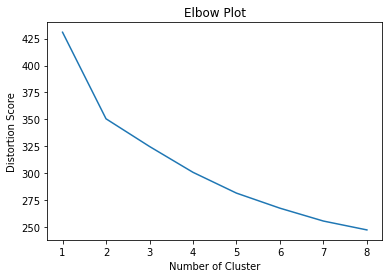

In [44]:
distortion = []
clusters = np.arange(2,10)

# creating array from the pivoted data
X = df_pivot.values.copy()   
    
# scaling the data 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# adding distortion score to a list for every cluster 
for n in clusters:
    kmeans = KMeans(n_clusters = n)
    cluster_found = kmeans.fit_predict(X)
    distortion.append(kmeans.inertia_)

dist_score = pd.DataFrame({'distortion': distortion, 'cluster': np.arange(1,n)})
plt.plot(dist_score['cluster'],dist_score['distortion'])
plt.title('Elbow Plot')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion Score')

`k = 2` seems like the best option here. However, this plot is not conclusive. Alternatively, 5 could be chosen. Next, a plot displaying the daily gas consumption patterns is created. It further shows the mean of the two clusters that were identified. 

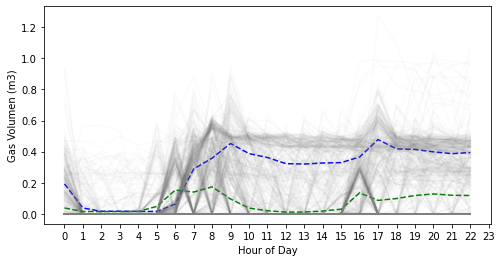

In [45]:
# clustering 
n = 2                                       # number of cluster 
kmeans = KMeans(n_clusters = n)             # intialising k-means 
cluster_found = kmeans.fit_predict(X)       # finding the cluster
cluster_series = pd.Series(cluster_found, name = 'cluster')
df_pivot['cluster'] = cluster_series.array  # adding cluster to df

# plotting gas consumption over a 24 hour period
fig, ax = plt.subplots(1,1, figsize=(8,4))
colors = ['blue', 'green']  
cluster_vals = np.arange(0, n)

# looping through all cluster for plotting 
for cluster, col in zip(cluster_vals, colors):
    df_pivot[df_pivot['cluster']== cluster][np.arange(0,23)].mean().plot(ax = ax, 
        legend=False, color=col, label= f'Cluster {cluster}', alpha=1, ls='--')
    df_pivot[df_pivot['cluster']== cluster][np.arange(0,23)].T.plot(ax = ax, 
        legend = False, alpha = 0.03, color = 'grey')
    
ax.set_xticks(np.arange(0,24))
ax.set_ylabel('Gas Volumen (m3)')
ax.set_xlabel('Hour of Day')
plt.grid(False)

There is a high and a low consumption pattern, which could be interpreted as weekday/weekend pattern or as a winter/summer consumption. Next, both hypotheses are tested. 

In [46]:
df_pivot['date'] = pd.to_datetime(df_pivot.index, format='%Y/%m/%d')
df_pivot['weekday'] = df_pivot['date'].dt.day_name()
df_pivot['month'] = df_pivot['date'].dt.month

In [47]:
pd.crosstab(index=df_pivot['cluster'], columns=df_pivot['weekday'])

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
cluster,,,,,,,
0,23,34,27,30,34,31,27
1,59,48,55,52,48,50,54


In [48]:
pd.crosstab(index=df_pivot['cluster'], columns=df_pivot['month'])

month,1,2,3,4,5,6,7,8,9,10,11,12
cluster,,,,,,,,,,,,
0,53,44,22,3,0,0,0,0,0,3,35,46
1,9,12,40,54,31,30,31,31,30,57,25,16


From the above tables, it can be seen that the clusters represent the winter/summer consumption pattern. Cluster 1 is only present in the winter months. However, cluster 2 is not as uniquely identifiable as winter. It should also be noted that winter is overrepresented, as the dataset starts in October 2013 and it ends in April 2015. 

## Principle Component Analysis (PCA)

Now, the principle component analysis can be performed and plotted. 

In [49]:
pca = PCA(2).fit_transform(X)                 # PCA with 2 principal componentes
label = kmeans.fit_predict(pca)               # defining a label for each value      
centroids = np.array(kmeans.cluster_centers_) # getting the centroids 

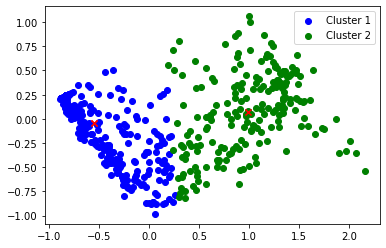

In [50]:
# for every cluster plot principal comps against each other + centroids
for cluster, col in zip(cluster_vals, colors):
    plt.scatter(pca[label == cluster, 0], pca[label == cluster, 1], 
                label = f'Cluster {(cluster+1)}', color = col)
    plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='r')
    
plt.legend()
plt.show()

The clusters are acceptable but not optimally separated. Ideally, we would like clusters that are far apart from each other and close to their own centroid. 

## Conclusion 
Clustering gas usage patterns over 24-hour periods with k-means, resulted in a successful identification of winter and summer gas demand patterns. Peaks during the morning and in the evening were observed. This is typical for household gas consumption, but the evening peaks are earlier than the UK average [18]. `Cluster 1` (blue) peaks earlier in the morning than `Cluster 2` (green). This makes sense as in winter one tends to get up later due to a later sunrise.  

A limitation of k-means clustering is that the k-value must be picked. The random  initialisation of centroids can also be a problem as results are not consistent. Another limitation is that k-means assumes that all cluster are of approximately the same size - it won't do well at detecting small clusters. Similarly, it won't perform well when there are outliers present in a cluster. Furthermore, k-means can only deal with numerical data. This is not a problem in this case but could be limiting in other use cases.

This analysis was only performed for one dwelling. It might be interesting to perform it on all 20 dwellings in the REFIT dataset. 